This notebook contains code for experiments I ran for my article on cosine annealing with restart.

As the training took many hours I am not sure if just doing 'run all cells' will work - there might be corrections you might need to make.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.plots import *
from utils import *
from resnet import *

In [3]:
print_info()

Last run on: 2018-02-23
PyTorch version: 0.3.1.post2
fastai version: 0.6


In [4]:
PATH = 'data/'
get_cifar10(PATH) # this is destructive - run only if you are okay to lose whatever you have under PATH/cifar10

In [5]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [6]:
create_val('data/cifar10/train', 0.1)

In [7]:
create_sample('data/cifar10/train', 0.01)
create_sample('data/cifar10/valid', 0.01)
create_sample('data/cifar10/test', 0.01)

In [6]:
def get_data(sz, bs, sample=False):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8, pad_mode=cv2.BORDER_CONSTANT)
    return ImageClassifierData.from_paths(
        f'{PATH}cifar10/',
        trn_name='train' if not sample else 'train_sample',
        val_name='valid' if not sample else 'valid_sample',
        test_name='test'if not sample else 'train_sample',
        tfms=tfms,
        bs=bs,
        test_with_labels=True
    )

In [130]:
bs = 128
sample = False
sz = 32

In [8]:
data = get_data(sz, bs, False)

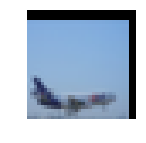

In [9]:
plots(data.trn_ds.denorm(data.trn_ds[0][0]), figsize=(2,2))

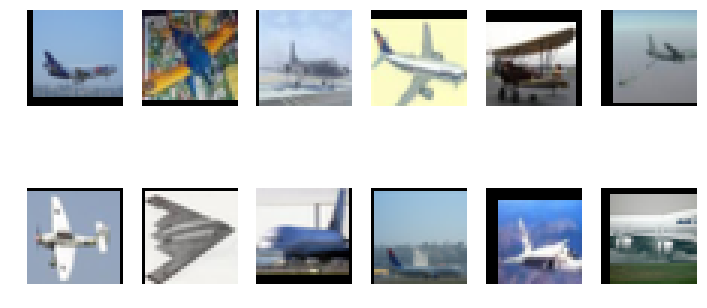

In [27]:
ims = [data.trn_ds.denorm(data.trn_ds[i][0]) for i in range(12)]
plots(np.stack(ims).squeeze(), rows=2)

# Experiments

## Training time

In [132]:
data = get_data(sz, bs, sample)

In [133]:
def create_model():
    m = nn.Sequential(resnet20(), nn.LogSoftmax())
    return ConvLearner.from_model_data(m, data)

In [134]:
class StopAtVal(Callback):
    def __init__(self, val_acc, learner, pickle_path, prefix):
        if not os.path.isfile(pickle_path):
            pd.to_pickle([], pickle_path)
        self.epoch = 1
        self.val_acc = val_acc
        self.learner = learner
        self.pickle_path = pickle_path
        self.prefix = prefix

    def on_epoch_end(self, metrics):
        val_acc = metrics[1]
        if  val_acc >= self.val_acc:
            res = pd.read_pickle(self.pickle_path)
            name = f'{self.prefix}_{len(res)+1}_{int(val_acc*100)}'
            self.learner.save(f'{name}')
            test_acc = accuracy_np(*learn.predict_with_targs(is_test=True))
            res.append([self.epoch, val_acc, test_acc, name])
            pd.to_pickle(res, pickle_path)
            return True
        self.epoch += 1

In [135]:
%%time
%%capture
pickle_path = 'data/epoch_counts_for_manual_lds.pickle'
for i in range(20):
    learn = create_model()
    learn.fit(1e-1, 90, wds=1e-4, callbacks=[StopAtVal(0.85, learn, pickle_path, 'manual')])

CPU times: user 2h 55min 59s, sys: 1h 1min 58s, total: 3h 57min 58s
Wall time: 2h 8min 35s


In [136]:
%%time
%%capture
pickle_path = 'data/epoch_counts_for_cosine_annealing.pickle'
for i in range(20):
    learn = create_model()
    learn.fit(1e-1, 90, cycle_len=1, wds=1e-4, callbacks=[StopAtVal(0.85, learn, pickle_path, 'cosine_annealing')])

CPU times: user 2h 48min 36s, sys: 58min 56s, total: 3h 47min 33s
Wall time: 2h 3min 11s


In [158]:
man = pd.read_pickle('data/epoch_counts_for_manual_lds.pickle')
ca = pd.read_pickle('data/epoch_counts_for_cosine_annealing.pickle')

In [159]:
man_epoch_count = np.array([r[0] for r in man])
ca_epoch_count = np.array([r[0] for r in ca])

In [160]:
np.median(man_epoch_count), np.median(ca_epoch_count)

(30.5, 21.0)

In [32]:
df = pd.DataFrame({'fixed weight decay schedule': man_epoch_count, 'cosine annealing with restarts': ca_epoch_count})
df = df.melt(value_vars=df.columns, var_name='wds', value_name='epoch')
df.sort_index(ascending=False, inplace=True)

Text(-0.5,-12,'\nStopping criterion: 15% error rate on 5k validation set.\nMedian run lengths: 30.5 and 21.')

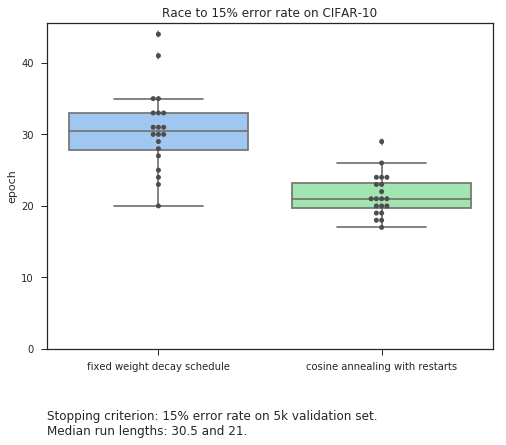

In [34]:
rcParams['figure.figsize'] = 8,6

sns.set(style="ticks")
y=[man_epoch_count, ca_epoch_count]
x=[1,2]



ax = sns.boxplot(data=df, y='epoch', x='wds', palette='pastel')
sns.swarmplot(data=df, y='epoch', x='wds', color='.3')
ax.yaxis.set_view_interval(0, 45)
ax.set_title('Race to 15% error rate on CIFAR-10')
ax.set_xlabel('')

text = """
Stopping criterion: 15% error rate on 5k validation set.
Median run lengths: 30.5 and 21."""
ax.text(-0.5, -12, text, fontsize=12)

### Model accuracy

In [180]:
class SaveBestValAcc(Callback):
    def __init__(self, cycle_len, learner):
        self.cycle_len = cycle_len
        self.learner = learner
        
        self.best_val_loss = np.inf
        self.best_val_acc = 0
        
    def on_epoch_end(self, metrics):
        if self.best_val_loss > metrics[0]:
            self.best_val_loss = metrics[0]
            self.learner.save(f'{str(self.cycle_len)}_loss')
            
        if self.best_val_acc < metrics[1]:
            self.best_val_acc = metrics[1] 
            self.learner.save(f'{str(self.cycle_len)}_acc')
        
    def on_train_end(self):
        self.learner.load(f'{str(self.cycle_len)}_loss')
        test_loss_acc = accuracy_np(*learn.predict_with_targs(is_test=True))
        self.learner.load(f'{str(self.cycle_len)}_acc')
        test_acc_acc = accuracy_np(*learn.predict_with_targs(is_test=True))
        
        vals = pd.read_pickle(pickle_path)
        vals.append((self.best_val_loss, test_loss_acc, self.best_val_acc, test_acc_acc))
        
        pd.to_pickle(vals, pickle_path)

In [ ]:
%%time
%%capture

max_epoch = 182


for cycle_len in [7, 14]:
    pickle_path = os.path.join(PATH, f'best_{cycle_len}.pickle')
    pd.to_pickle([], pickle_path)
    
    for _ in range(10):
        cycle_count = int(max_epoch / cycle_len)
        learn = create_model()
        learn.fit(1e-1, cycle_count, cycle_len=cycle_len, wds=1e-4, callbacks=[SaveBestValAcc(cycle_len, learn)])

In [200]:
results7 = pd.read_pickle(os.path.join(PATH, 'best_7.pickle'))
results14 = pd.read_pickle(os.path.join(PATH, 'best_14.pickle'))

In [201]:
loss7 = [r[1] for r in results7]
acc7 = [r[3] for r in results7]
loss14 = [r[1] for r in results14]
acc14 = [r[3] for r in results14]

In [203]:
np.mean(loss7), np.median(loss7), np.mean(acc7), np.median(acc7)

(0.90901999999999994,
 0.91034999999999999,
 0.90983999999999998,
 0.90955000000000008)

In [204]:
np.mean(loss14), np.median(loss14), np.mean(acc14), np.median(acc14)

(0.90871000000000013, 0.90825, 0.91098999999999997, 0.91090000000000004)

Not planning on reading too much into the difference on whether we stop on accuracy or on loss. Before running the training I reasoned we should be stopping on accuracy but just wanted to see how the results compare.

Anyhow, going with the results when stopped on accuracy

In [238]:
df = pd.DataFrame({7: acc7, 14: acc14})
df = df.melt(value_vars=df.columns, var_name='cycle len', value_name='test set accuracy')
df.sort_index(ascending=True, inplace=True)

In [302]:
df['test set accuracy'] = (1 - df['test set accuracy']) * 100

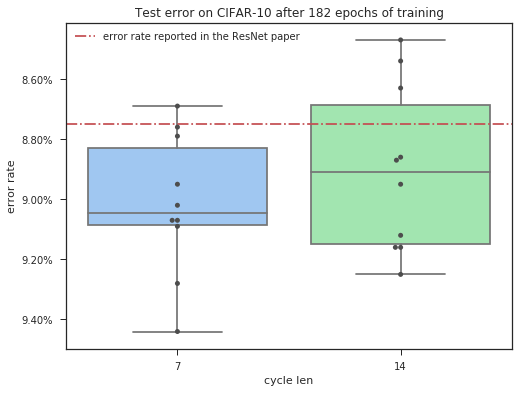

In [311]:
rcParams['figure.figsize'] = 8,6

sns.set(style="ticks")
y=[man_epoch_count, ca_epoch_count]
x=[1,2]



ax = sns.boxplot(data=df, y='test set accuracy', x='cycle len', palette='pastel')
sns.swarmplot(data=df, y='test set accuracy', x='cycle len', color='.3')
plt.plot([-0.5, 1.5], [8.75, 8.75], '-.', color=sns.color_palette()[2], label='error rate reported in the ResNet paper')
ax.set_title('Test error on CIFAR-10 after 182 epochs of training')
ax.set_ylabel('error rate')
plt.gca().invert_yaxis()

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x) for x in vals])

plt.legend()